<a href="https://colab.research.google.com/github/ashish-saha/Subject_Recognition_Using_LSTM_for_HAR_Dataset/blob/main/LSTM_Subject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -LO "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58.1M    0 58.1M    0     0  13.2M      0 --:--:--  0:00:04 --:--:-- 13.2M


In [2]:
!unzip human+activity+recognition+using+smartphones.zip

Archive:  human+activity+recognition+using+smartphones.zip
 extracting: UCI HAR Dataset.names   
 extracting: UCI HAR Dataset.zip     


In [3]:
%%capture
!unzip "UCI HAR Dataset.zip"

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from sklearn.experimental import enable_iterative_imputer  # Required to enable
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
keras.utils.set_random_seed(142)

# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [79]:
## get the data from txt files to pandas dataffame
# training data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = features
X_train['Activity'] = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'])

# training labels
y_train_subject = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', names=['subject'])
X_train['subject'] = y_train_subject

<ipython-input-79-76fd5a8203ee>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


In [80]:
# test data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = features
X_test['Activity'] = pd.read_csv('UCI HAR Dataset/test/y_test.txt', names=['Activity'])

# test labels
y_test_subject = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', names=['Activity'])
X_test['subject'] = y_test_subject

<ipython-input-80-abe73ffddcd5>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


In [81]:
# Combine both train and test data
all_X_data = pd.concat([X_train, X_test], axis=0)
all_X_data = all_X_data.reset_index(drop=True)

all_y_data = pd.concat([y_train_subject, y_test_subject], axis=0)
all_y_data = all_y_data.reset_index(drop=True)

In [82]:
all_X_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,5,1


In [83]:
# Split the test train data
subject_train, subject_test = train_test_split(all_X_data, test_size=0.2, random_state=42)
subject_train = subject_train.reset_index(drop=True)
subject_test = subject_test.reset_index(drop=True)

In [84]:
# We have to do this because some of the features have duplicate names
# Original column names
original_columns = subject_train.columns.tolist()

# Function to append axis labels (-X, -Y, -Z) for repeated features
def append_axis_labels(features):
    updated_features = []
    count_dict = {}  # To track the occurrence of each feature
    axes = ['-X', '-Y', '-Z']  # Axis labels

    for feature in features:
        # If the feature has been seen before, assign the next axis label
        if feature in count_dict:
            count_dict[feature] += 1
        else:
            count_dict[feature] = 0  # Initialize for first occurrence

        # Append the appropriate axis label
        axis_label = axes[count_dict[feature] % len(axes)]  # Cycle through -X, -Y, -Z
        updated_features.append(feature.replace("bandsEnergy()", f"bandsEnergy(){axis_label}"))

    return updated_features

# Update column names
updated_columns = append_axis_labels(original_columns)

# Assign updated column names to the DataFrame
subject_train.columns = updated_columns
subject_test.columns = updated_columns

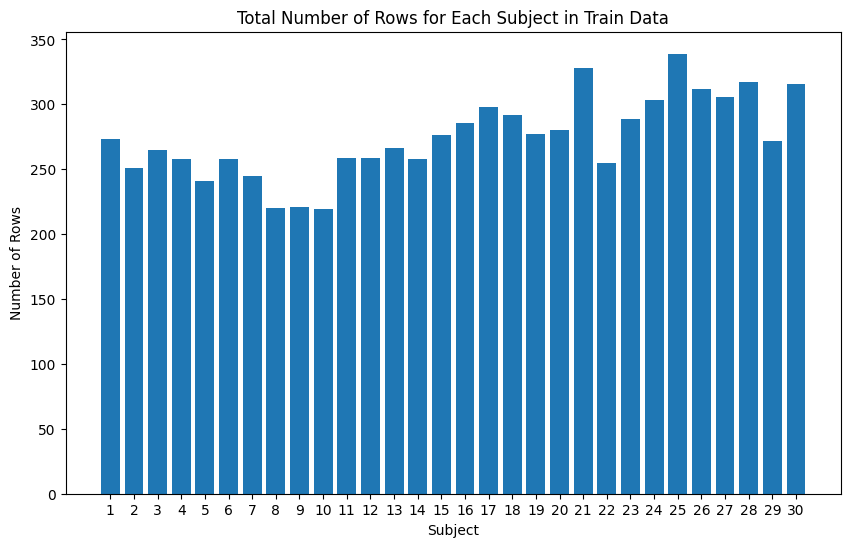

In [85]:
# Plotting the bar graph
values, counts = np.unique(subject_train['subject'], return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(values, counts)
plt.xlabel('Subject')
plt.ylabel('Number of Rows')
plt.title('Total Number of Rows for Each Subject in Train Data')
plt.xticks(values)  # Set x-axis ticks to subject numbers
plt.show()

In [86]:
y_train = subject_train['subject']
X_train = subject_train.drop('subject', axis=1)

y_test = subject_test['subject']
X_test = subject_test.drop('subject', axis=1)

# of the participants range from 0-29, needed for one hot encoding
y_train = y_train - 1
y_test = y_test - 1

# one hot encode y
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [87]:
## Doesnt work, training accuracy is high but validation accuracy is low (like 3 %, basically random)

# # Assuming you want 200 time steps
# time_steps = 200

# # Compute the number of samples after adjusting for time steps
# train_num_samples = X_train.shape[0] // time_steps
# test_num_samples = X_test.shape[0] // time_steps


# valid_train_row_count = (X_train.shape[0] // time_steps) * time_steps
# valid_test_row_count = (X_test.shape[0] // time_steps) * time_steps

# # Reshape the data to be in 3D (num_samples, time_steps, num_features)
# X_train = np.array(X_train[:valid_train_row_count]).reshape((train_num_samples, time_steps, X_train[:valid_train_row_count].shape[1]))
# X_test = np.array(X_test[:valid_test_row_count]).reshape((test_num_samples, time_steps, X_test[:valid_test_row_count].shape[1]))

In [88]:
# Assuming you want 1 time steps
time_steps = 1

# Compute the number of samples after adjusting for time steps
train_num_samples = X_train.shape[0] // time_steps
test_num_samples = X_test.shape[0] // time_steps


# Reshape the data to be in 3D (num_samples, time_steps, num_features)
X_train_reshaped = np.array(X_train).reshape((train_num_samples, time_steps, X_train.shape[1]))
X_test_reshaped = np.array(X_test).reshape((test_num_samples, time_steps, X_test.shape[1]))

In [89]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(y_train.shape[1], activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │         353,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,998 (1.39 MB)

 Trainable params: 363,998 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model_history = model.fit(X_train_reshaped, y_train, epochs = 300, validation_split = 0.20, batch_size = 1024, verbose = 1)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.0362 - loss: 3.4017 - val_accuracy: 0.0504 - val_loss: 3.3769
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.0505 - loss: 3.3675 - val_accuracy: 0.1038 - val_loss: 3.3391
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1006 - loss: 3.3160 - val_accuracy: 0.1153 - val_loss: 3.2712
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.1245 - loss: 3.2330 - val_accuracy: 0.1365 - val_loss: 3.1723
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.1554 - loss: 3.1265 - val_accuracy: 0.1657 - val_loss: 3.0518
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1899 - loss: 3.0082 - val_accuracy: 0.2239 - val_loss: 2.9319
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2388 - loss: 2.8705 - val_accuracy: 0.2500 - val_loss: 2.7927
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2822 - loss: 2.7415 - val_accuracy: 0.2979 - val_los

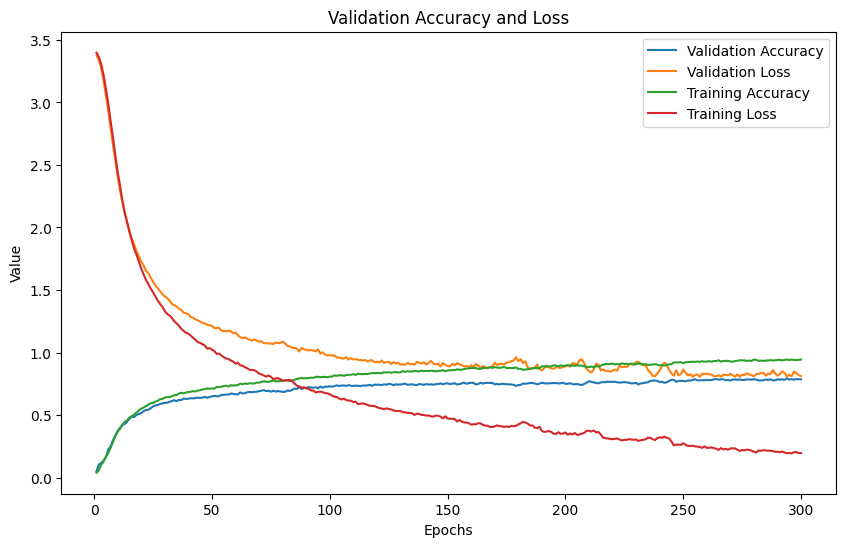

In [92]:
epochs = range(1, len(model_history.history['accuracy']) + 1)

plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(epochs, model_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, model_history.history['val_loss'], label='Validation Loss')

# Accuracy plot
plt.plot(epochs, model_history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, model_history.history['loss'], label='Training Loss')

plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Display the plot
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


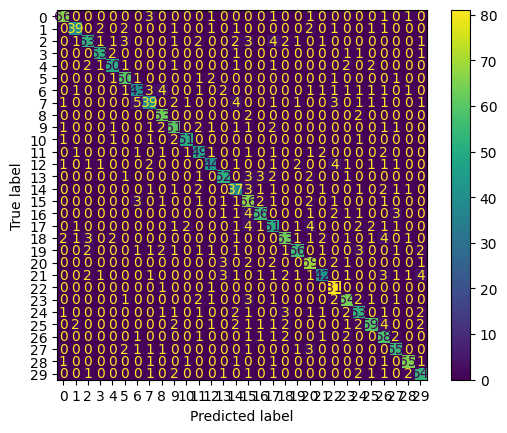

In [93]:
predictions = model.predict(X_test_reshaped)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [94]:
model.evaluate(X_test_reshaped, y_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8001 - loss: 0.7517


[0.7426591515541077, 0.8019417524337769]

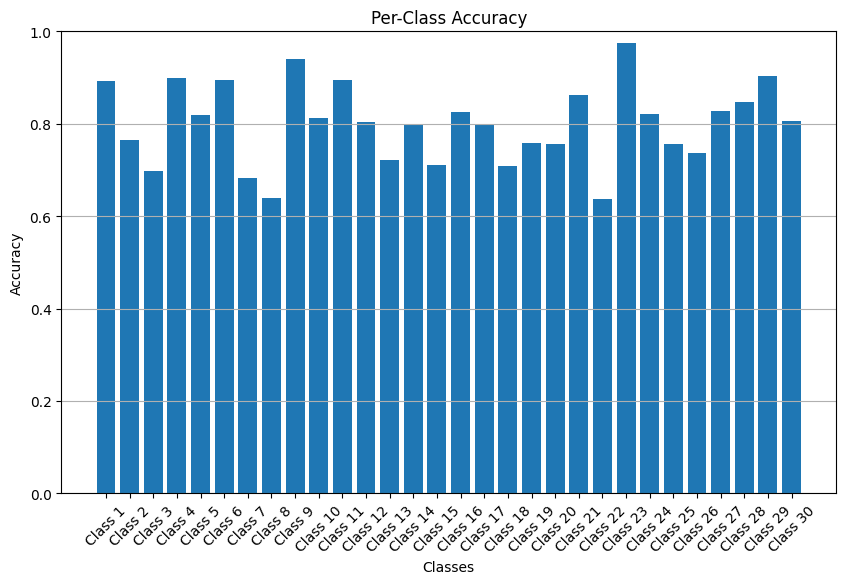

In [95]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)  # Calculate per-class accuracy
label_dict = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

# Plot per-class accuracy
classes = [f'Class {i+1}' for i in range(len(class_accuracies))]
plt.figure(figsize=(10, 6))
plt.bar(classes, class_accuracies)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [96]:
activity_labels = X_test['Activity']
unique_activities = np.unique(activity_labels)
activity_accuracy = {}

for activity in unique_activities:
    # Get indices for samples belonging to the current activity
    indices = np.where(activity_labels == activity)[0]

    # Extract true and predicted labels for this activity
    true_for_activity = y_test_pred[indices]
    pred_for_activity = predictions[indices]

    # Calculate accuracy for this activity
    accuracy = accuracy_score(true_for_activity, pred_for_activity)
    activity_accuracy[activity] = accuracy

# Display accuracy for each activity
for activity, accuracy in activity_accuracy.items():
    print(f"Accuracy for activity {activity}: {accuracy * 100:.2f}%")

Accuracy for activity 1: 99.46%
Accuracy for activity 2: 97.41%
Accuracy for activity 3: 96.13%
Accuracy for activity 4: 60.21%
Accuracy for activity 5: 58.76%
Accuracy for activity 6: 77.34%


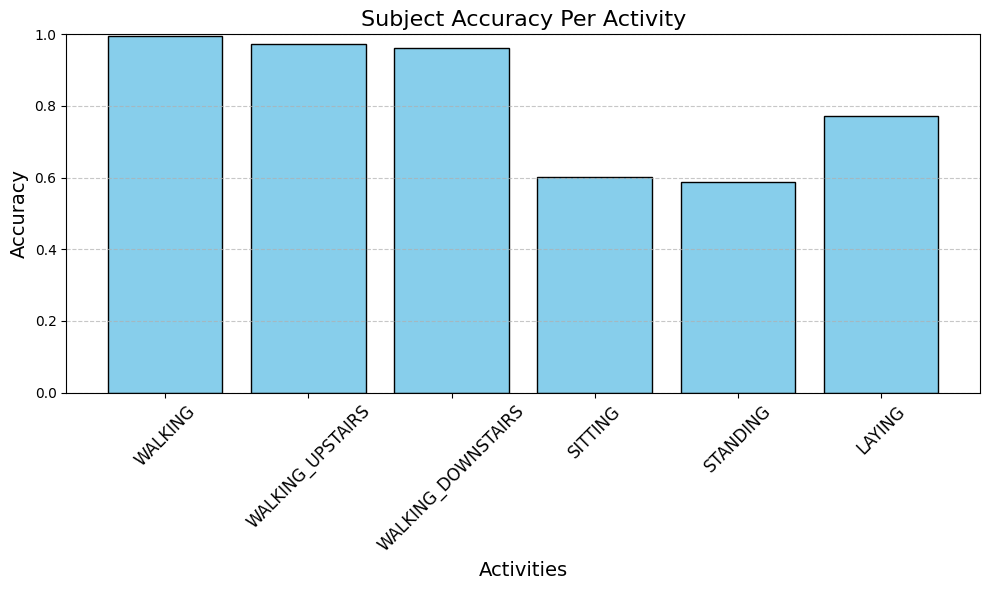

In [97]:
label_dict = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

activity_labels = [label_dict[activity] for activity in activity_accuracy.keys()]
accuracy_values = list(activity_accuracy.values())
x = np.arange(len(activity_labels))
plt.figure(figsize=(10, 6))
plt.bar(x, accuracy_values, color='skyblue', edgecolor='black')
plt.title("Subject Accuracy Per Activity", fontsize=16)
plt.xlabel("Activities", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(ticks=x, labels=activity_labels, rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [98]:
def simulate_multiple_missing_intervals(df, acc_columns, gyro_columns, acc=True, gyro=True, missing_duration=4, sampling_rate=50, num_intervals=1):
    """
    Simulates multiple intervals of missing data for accelerometer or gyroscope ensuring no overlap.

    Args:
        df: DataFrame containing the dataset.
        acc_columns: List of accelerometer-specific columns.
        gyro_columns: List of gyroscope-specific columns.
        missing_duration: Duration of missing data in seconds for each interval.
        sampling_rate: Number of samples per second.
        num_intervals: Number of intervals with missing data.

    Returns:
        Modified DataFrame with missing data for accelerometer or gyroscope (but not both).
    """
    df_copy = df.copy()
    missing_samples = missing_duration * sampling_rate
    total_rows = len(df)
    used_intervals = []
    acc_start_idx = len(df)
    acc_end_idx = 0

    for _ in range(num_intervals):
        if acc:
            # Randomly select rows for accelerometer missing data
            acc_start_idx = np.random.randint(0, total_rows - missing_samples + 1)
            acc_end_idx = acc_start_idx + missing_samples

            # Ensure no overlap with previously selected intervals
            while any(start <= acc_end_idx and end >= acc_start_idx for start, end in used_intervals):
                acc_start_idx = np.random.randint(0, total_rows - missing_samples + 1)
                acc_end_idx = acc_start_idx + missing_samples

            # Mask accelerometer data
            df_copy.iloc[acc_start_idx:acc_end_idx, df.columns.get_indexer(acc_columns)] = np.nan # 0
            used_intervals.append((acc_start_idx, acc_end_idx))

        if gyro:
            # Randomly select rows for gyroscope missing data ensuring no overlap
            gyro_start_idx = np.random.randint(0, total_rows - missing_samples + 1)
            gyro_end_idx = gyro_start_idx + missing_samples

            while (any(start <= gyro_end_idx and end >= gyro_start_idx for start, end in used_intervals) or
                  (gyro_start_idx <= acc_end_idx and gyro_end_idx >= acc_start_idx)):
                gyro_start_idx = np.random.randint(0, total_rows - missing_samples + 1)
                gyro_end_idx = gyro_start_idx + missing_samples

            # Mask gyroscope data
            df_copy.iloc[gyro_start_idx:gyro_end_idx, df.columns.get_indexer(gyro_columns)] = np.nan # 0
            used_intervals.append((gyro_start_idx, gyro_end_idx))

    return df_copy, used_intervals



In [99]:
def pca_imputation(df, imputation_method='SimpleImputer', n_components=None):
    """
    Imputes missing values using PCA.

    Args:
        df: DataFrame with missing values (NaN).
        n_components: Number of principal components to retain. If None, retain all.

    Returns:
        DataFrame with imputed values.
    """
    # Step 1: Impute initial missing values with the mean

    if imputation_method=='SimpleImputer':
        imputer = SimpleImputer(strategy='mean')
        imputed_data = imputer.fit_transform(df)
    elif imputation_method=='KNNImputer':
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_data = imputer.fit_transform(df)
    elif imputation_method=='IterativeImputer':
        imputer = IterativeImputer(max_iter=5, random_state=42)
        imputed_data = imputer.fit_transform(df)

    # if enable_pca:
    print ("Doing Principle Component Analysis")
    # Step 2: Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(imputed_data)

    # Step 3: Reconstruct data from principal components
    imputed_pca_data = pca.inverse_transform(principal_components)

    # Step 4: Fill back into DataFrame format
    df_imputed = pd.DataFrame(imputed_data, columns=df.columns, index=df.index)
    df_imputed_pca = pd.DataFrame(imputed_pca_data, columns=df.columns, index=df.index)


    return df_imputed, df_imputed_pca

In [100]:
Combinations_of_data = [
    (True, True, 1, 5),
    (True, True, 5, 1),
    (True, False, 5, 2),
    (False, True, 5, 2),
    (True, False, 10, 1),
    (False, True, 10, 1)
]

In [101]:
results = []

# Example Usage
for data in Combinations_of_data:
    # Define accelerometer and gyroscope columns
    accelerometer_cols = [col for col in X_train.columns if 'Acc' in col]
    gyroscope_cols = [col for col in X_train.columns if 'Gyro' in col]

    # Simulate multiple intervals of missing data
    # X_train_modified, X_train_intervals = simulate_multiple_missing_intervals(
    #     X_train, accelerometer_cols, gyroscope_cols, num_intervals=5)
    X_test_modified, X_test_intervals = simulate_multiple_missing_intervals(
        X_test, accelerometer_cols, gyroscope_cols, acc=data[0], gyro=data[1], missing_duration=data[2], num_intervals=data[3])

    # Display the intervals with missing data
    # print("Intervals with missing data for train data (start, end):")
    # for interval in X_train_intervals:
    #     print(interval)
    print("Intervals with missing data for test data (start, end):")
    for interval in X_test_intervals:
        print(interval)

    # Step 1: Replace 0 with NaN for accelerometer and gyroscope columns
    X_test_modified_nan = X_test_modified.copy()
    for col in accelerometer_cols + gyroscope_cols:
        X_test_modified_nan[col] = X_test_modified_nan[col].replace(0, np.nan)

    # Step 2: Verify missing values
    missing_count = X_test_modified_nan.isna().sum().sum()
    print(f"Missing values after replacing 0 with NaN: {missing_count}")

    # Step 3: Apply PCA imputation
    X_test_SimpleImputer, X_test_SimpleImputer_with_PCA = pca_imputation(X_test_modified_nan, imputation_method='SimpleImputer', n_components=175)
    X_test_KNNImputer, X_test_KNNImputer_with_PCA = pca_imputation(X_test_modified_nan, imputation_method='KNNImputer', n_components=175)
    # X_test_IterativeImputer, X_test_IterativeImputer_with_PCA = pca_imputation(X_test_modified_nan, imputation_method='IterativeImputer', n_components=175)

    # Step 4: Check results
    print("Missing values before PCA imputation :", X_test_modified_nan.isna().sum().sum())

    print("Missing values after SimpleImputer:", X_test_SimpleImputer.isna().sum().sum())
    print("Missing values after KNNImputer:", X_test_KNNImputer.isna().sum().sum())
    # print("Missing values after IterativeImputer:", X_test_IterativeImputer.isna().sum().sum())

    print("Missing values after PCA SimpleImputer:", X_test_SimpleImputer_with_PCA.isna().sum().sum())
    print("Missing values after PCA KNNImputer:", X_test_KNNImputer_with_PCA.isna().sum().sum())
    # print("Missing values after PCA IterativeImputer:", X_test_IterativeImputer_with_PCA.isna().sum().sum())

    # Reshape the data to be in 3D (num_samples, time_steps, num_features)
    # X_train_modified_reshaped = np.array(X_train_modified).reshape((train_num_samples, time_steps, X_train_modified.shape[1]))
    X_test_modified_reshaped = np.array(X_test_modified).reshape((test_num_samples, time_steps, X_test_modified.shape[1]))


    # Reshape the data to be in 3D (num_samples, time_steps, num_features)
    # X_train_imputed_reshaped = np.array(X_train_imputed).reshape((train_num_samples, time_steps, X_train_imputed.shape[1]))
    X_test_SimpleImputer_reshaped = np.array(X_test_SimpleImputer).reshape((test_num_samples, time_steps, X_test_SimpleImputer.shape[1]))
    X_test_KNNImputer_reshaped = np.array(X_test_KNNImputer).reshape((test_num_samples, time_steps, X_test_KNNImputer.shape[1]))
    # X_test_IterativeImputer_reshaped = np.array(X_test_IterativeImputer).reshape((test_num_samples, time_steps, X_test_IterativeImputer.shape[1]))

    X_test_SimpleImputer_with_PCA_reshaped = np.array(X_test_SimpleImputer_with_PCA).reshape((test_num_samples, time_steps, X_test_SimpleImputer_with_PCA.shape[1]))
    X_test_KNNImputer_with_PCA_reshaped = np.array(X_test_KNNImputer_with_PCA).reshape((test_num_samples, time_steps, X_test_KNNImputer_with_PCA.shape[1]))
    # X_test_IterativeImputer_with_PCA_reshaped = np.array(X_test_IterativeImputer_with_PCA).reshape((test_num_samples, time_steps, X_test_IterativeImputer_with_PCA.shape[1]))


    results.append((
        X_test_modified_nan.isna().sum().sum(),
        model.evaluate(X_test_modified_reshaped, y_test)[1],
        model.evaluate(X_test_SimpleImputer_reshaped, y_test)[1],
        model.evaluate(X_test_KNNImputer_reshaped, y_test)[1],
        model.evaluate(X_test_SimpleImputer_with_PCA_reshaped, y_test)[1],
        model.evaluate(X_test_KNNImputer_with_PCA_reshaped, y_test)[1]
    ))


Intervals with missing data for test data (start, end):
(277, 327)
(1221, 1271)
(411, 461)
(511, 561)
(1292, 1342)
(1050, 1100)
(173, 223)
(1616, 1666)
(653, 703)
(1420, 1470)
Missing values after replacing 0 with NaN: 139650
Doing Principle Component Analysis
Doing Principle Component Analysis
Missing values before PCA imputation : 139650
Missing values after SimpleImputer: 0
Missing values after KNNImputer: 0
Missing values after PCA SimpleImputer: 0
Missing values after PCA KNNImputer: 0
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6032 - loss: nan
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6258 - loss: 2.9997
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7283 - loss: 1.1606
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6119 - loss: 3.0533
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7126 - loss: 1.2010
Intervals with missing data for test data (start, end):
(302, 552)
(649, 899)
Missing values after replacing 0 with NaN: 139656
Doing Principl

In [102]:
print ("1 second ACC & 1 Second Gyro (5 seperate intervals for each) : {}, {}, {}, {}, {}, {}".format(results[0][0], results[0][1], results[0][2], results[0][3], results[0][4], results[0][5]) )
print ("5 second ACC & 5 Second Gyro (1 continuous intervals for each) : {}, {}, {}, {}, {}, {}".format(results[1][0], results[1][1], results[1][2], results[1][3], results[1][4], results[1][5]) )
print ("5 second ACC (2 seperate intervals) : {}, {}, {}, {}, {}, {}".format(results[2][0], results[2][1], results[2][2], results[2][3], results[2][4], results[2][5]) )
print ("5 Second Gyro (2 seperate intervals) : {}, {}, {}, {}, {}, {}".format(results[3][0], results[3][1], results[3][2], results[3][3], results[3][4], results[3][5]) )
print ("10 seconds ACC (1 continuous intervals) : {}, {}, {}, {}, {}, {}".format(results[4][0], results[4][1], results[4][2], results[4][3], results[4][4], results[4][5]) )
print ("10 seconds Gyro (1 continuous intervals) : {}, {}, {}, {}, {}, {}".format(results[5][0], results[5][1], results[5][2], results[5][3], results[5][4], results[5][5]) )

1 second ACC & 1 Second Gyro (5 seperate intervals for each) : 139650, 0.6150485277175903, 0.6417475938796997, 0.7339805960655212, 0.6281553506851196, 0.7199029326438904
5 second ACC & 5 Second Gyro (1 continuous intervals for each) : 139656, 0.6184465885162354, 0.6383495330810547, 0.7339805960655212, 0.6262136101722717, 0.7169902920722961
5 second ACC (2 seperate intervals) : 172630, 0.6179611682891846, 0.6412621140480042, 0.7441747784614563, 0.6276699304580688, 0.7281553149223328
5 Second Gyro (2 seperate intervals) : 106675, 0.6140776872634888, 0.6509708762168884, 0.7514563202857971, 0.6402912735939026, 0.7398058176040649
10 seconds ACC (1 continuous intervals) : 172629, 0.6155340075492859, 0.6339805722236633, 0.7475728392601013, 0.6233009696006775, 0.7339805960655212
10 seconds Gyro (1 continuous intervals) : 106675, 0.6169902682304382, 0.6490291357040405, 0.7587378621101379, 0.6378640532493591, 0.7480582594871521


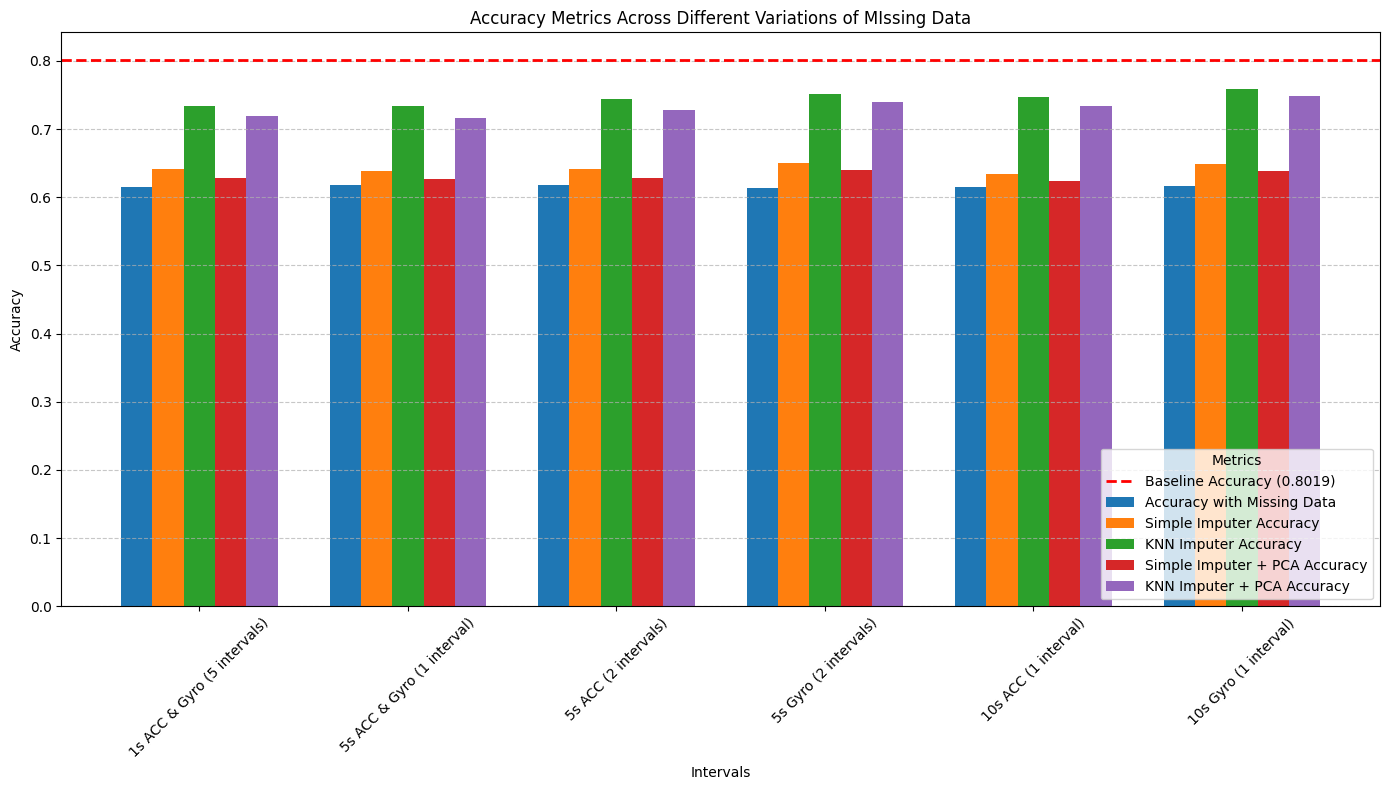

In [105]:
labels = [
    "1s ACC & Gyro (5 intervals)",
    "5s ACC & Gyro (1 interval)",
    "5s ACC (2 intervals)",
    "5s Gyro (2 intervals)",
    "10s ACC (1 interval)",
    "10s Gyro (1 interval)"
]

metric_labels = [
    "Accuracy with Missing Data",
    "Simple Imputer Accuracy",
    "KNN Imputer Accuracy",
    "Simple Imputer + PCA Accuracy",
    "KNN Imputer + PCA Accuracy"
]

# Baseline accuracy
baseline_accuracy = 0.8019

# Plotting the graph
metrics = np.array([item[1:] for item in results]).T  # Transpose for easier plotting
x = np.arange(len(labels))  # X-axis positions

# Plot a bar graph for each metric
bar_width = 0.15
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, metric, width=bar_width, label=metric_labels[i])

# Add baseline accuracy as a horizontal line
plt.axhline(y=baseline_accuracy, color='red', linestyle='--', linewidth=2, label=f'Baseline Accuracy ({baseline_accuracy})')

# Add labels, titles, and legend
plt.xticks(x + bar_width * (len(metrics) - 1) / 2, labels, rotation=45)
plt.xlabel("Intervals")
plt.ylabel("Accuracy")
plt.title("Accuracy Metrics Across Different Variations of MIssing Data")
plt.legend(title="Metrics", loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

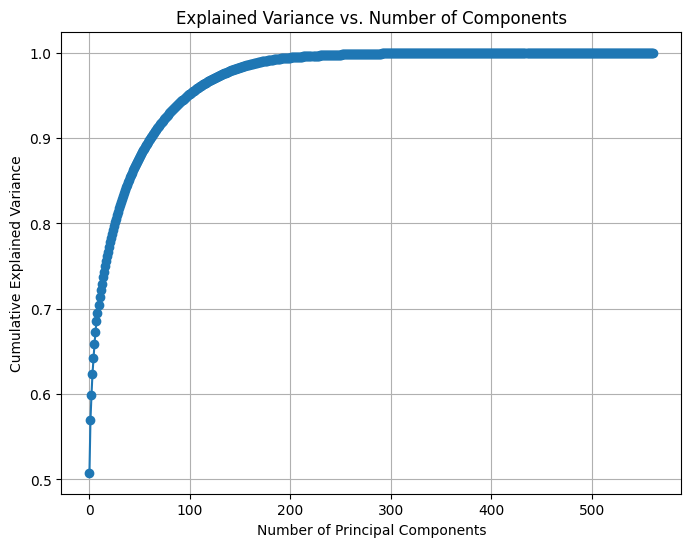

Number of components to retain for 99% variance: 175


In [104]:
# Finding the necessary number of Princicple Componenet

# Step 1: Impute missing data
imputer = SimpleImputer(strategy='mean')  # You can also try other strategies
data_imputed = imputer.fit_transform(X_test)

# Step 2: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Step 3: Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Step 4: Plot cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Step 5: Determine number of components to retain
threshold = .99  # Example threshold for 99% variance
num_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components to retain for {threshold*100:.0f}% variance: {num_components}")